# Inferring from AssociateTracksIPC.csv Data

In [1]:
# pip install matplotlib==3.3.4 -> Optional

In [2]:
import os
import sys
import glob
import h5py
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [3]:
import DGCNN_toolkit as nn
import analysis_toolkit as atk

In [4]:
df = pd.read_csv("AssociateTracksIPC.csv")
df.head()

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z
0,0,0,1,200,-2.799170e-07,-2.668260e-07,-2.663970e-07,0.475129,0.868961,-100,-100,21.9857,5.642750,-6.14229
1,0,1,1,201,-3.418840e-07,-3.295890e-07,-3.293660e-07,3.007230,2.900650,-100,-100,22.6302,6.033940,-7.05420
2,0,2,1,212,-2.565240e-07,-2.453990e-07,-2.439710e-07,20.595800,17.609300,-100,-100,23.5375,-1.296500,-20.38120
3,0,3,1,213,-3.151130e-07,-3.038010e-07,-3.015280e-07,2.340120,1.874320,-100,-100,23.5127,0.160025,-33.40430
4,0,4,1,223,-3.719570e-07,-3.589450e-07,-3.589730e-07,1.128670,0.657248,-100,-100,20.8133,-9.441430,-18.42680


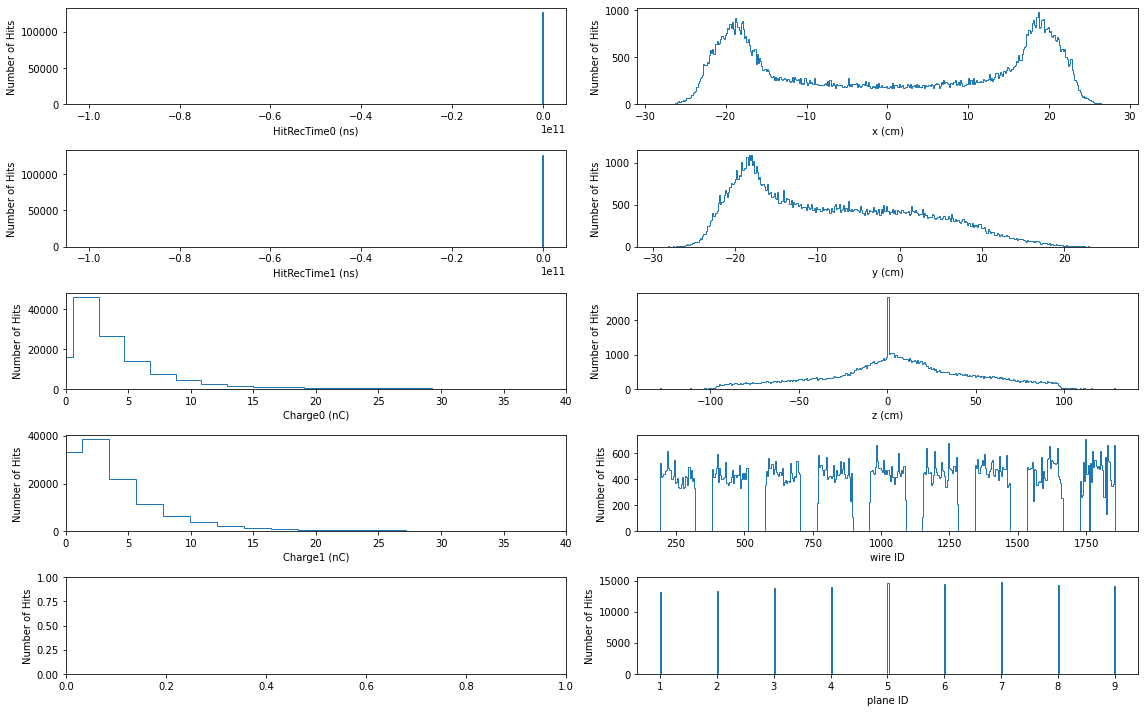

In [5]:
atk.sup_plot(df,400)

In [6]:
# Clearing Phase

clear_df = df[(df["Charge0"] != df["Charge1"]) &
                  (df.z > -100) & 
                  (df.z <  100) & 
                  (df.x > -30) & 
                  (df.x <  30) & 
                  (df.y > -30) & 
                  (df.y <  30) &
                  (df.timeRec >-600*1e-9) &
                  (df.timeRec <-200*1e-9) &
                  (df.HitRecTime0 >-1000*1e-9) &
                  (df.HitRecTime0 <0) &
                  (df.HitRecTime1 >-1000*1e-9) &
                  (df.HitRecTime1 <0)
                  ].dropna()

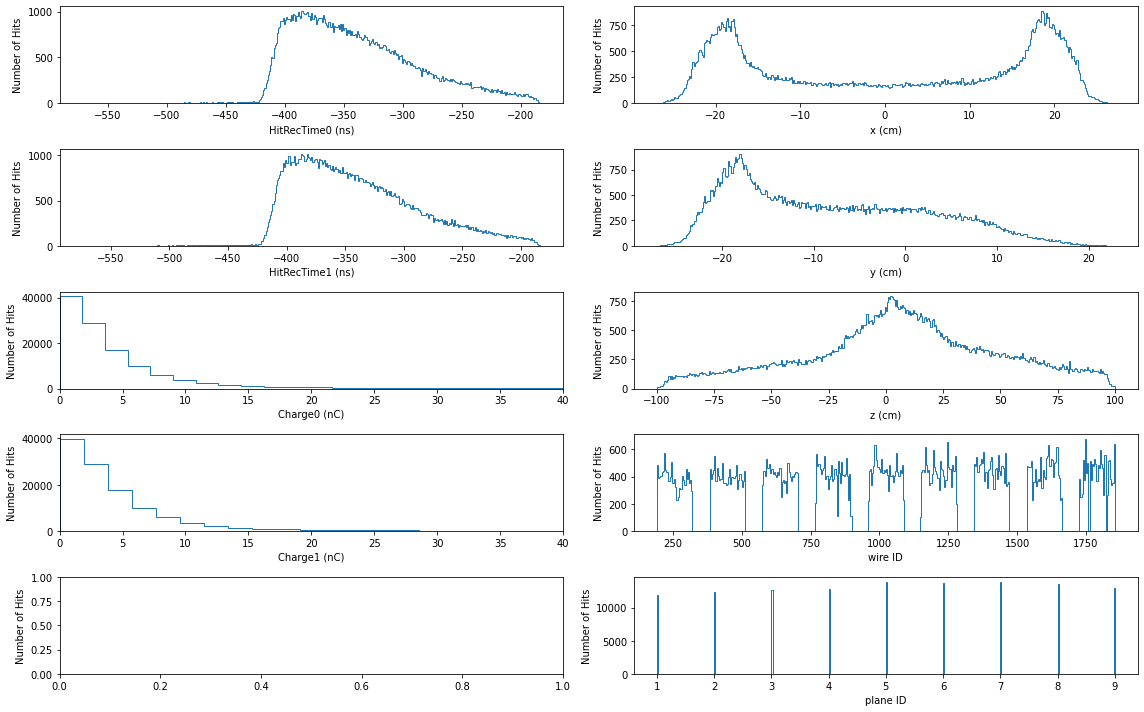

In [7]:
atk.sup_plot(clear_df, 400, savename="clear_df_all.png")

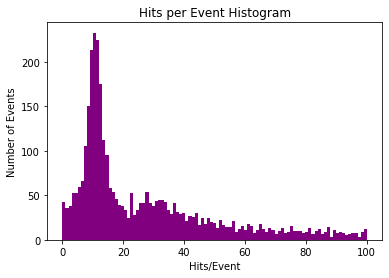

In [8]:
atk.draw_histogram(clear_df,
                   bins=np.linspace(0,100,100),
                   histo="hits per event",
                   histtype= "stepfilled",
                   color = "purple")

In [9]:
## Problem below.
# After some cuts we have non-subsequent hit indexing.
# Therefore, a reindexing of iHits is needed.
# Or just throw away randomly hits from events that have more than 432 hits.

In [10]:
#### This is a problem. The network was trained with 432 points.
# It cannot extrapolate automatically.
# We need to cut the events with more hits than 432.


(clear_df.shape[0] - clear_df[clear_df.iHit < 432].shape[0]) / (clear_df.shape[0])

0.0

In [11]:
# Okay we lost 2.0% of the data.
crop_df = clear_df[clear_df.iHit < 432]
crop_df = crop_df.reset_index(drop=True)
crop_df

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z
0,0,0,1,200,-2.799170e-07,-2.668260e-07,-2.663970e-07,0.475129,0.868961,-100,-100,21.9857,5.642750,-6.14229
1,0,1,1,201,-3.418840e-07,-3.295890e-07,-3.293660e-07,3.007230,2.900650,-100,-100,22.6302,6.033940,-7.05420
2,0,2,1,212,-2.565240e-07,-2.453990e-07,-2.439710e-07,20.595800,17.609300,-100,-100,23.5375,-1.296500,-20.38120
3,0,3,1,213,-3.151130e-07,-3.038010e-07,-3.015280e-07,2.340120,1.874320,-100,-100,23.5127,0.160025,-33.40430
4,0,4,1,223,-3.719570e-07,-3.589450e-07,-3.589730e-07,1.128670,0.657248,-100,-100,20.8133,-9.441430,-18.42680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117905,4998,6,5,1041,-3.638400e-07,-3.510520e-07,-3.506630e-07,1.878260,1.597230,-100,-100,-12.6584,-16.152100,10.41680
117906,4998,7,5,1042,-2.912810e-07,-2.786370e-07,-2.789220e-07,1.999010,2.042800,-100,-100,-12.0567,-15.900600,8.37652
117907,4998,8,7,1427,-4.089190e-07,-3.955960e-07,-3.963820e-07,2.436220,2.544290,-100,-100,-12.6069,-14.468400,8.22479
117908,4998,9,8,1623,-4.099570e-07,-3.974170e-07,-3.962830e-07,1.692540,1.889610,-100,-100,-11.8168,-13.799700,7.78838


In [12]:
clear_df.groupby("iEvent").count().iHit.max()

303

In [13]:
crop_df.groupby("iEvent").count().iHit.max()

303

In [14]:
num_classes = 5
num_hits = 432

data, label = nn.prepare_input(crop_df, "real", num_hits)

test = nn.Dataset(data, label, num_classes)

In [15]:
# ## Uncomment if you don't have enough RAM ###
#                                            
# del data, label                            
#                                            
# ## Uncomment if you don't have enough ram ###

In [16]:
input_shapes = {"points": (432,3),
                "features": (432,3),
                "mask": (432,1)}

model = nn.get_DGCNN(num_classes, input_shapes)

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=nn.lr_schedule(0)),
              metrics=["accuracy"])
model.summary()

Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 432, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 432, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 432, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 432, 1)]     0           tf_op_layer_Cast[0][0]           
___________________________________________________________________________________________

In [18]:
test.X["points"].shape

(3613, 432, 3)

In [19]:
model.load_weights("model_checkpoints/DGCNN_modelbest_wn_onnx.h5")

pred = model.predict(test.X)

In [20]:
pred = pred.reshape(-1,num_hits,num_classes)

In [21]:
np.unique(pred.reshape(-1,num_classes).argmax(-1),return_counts=True)

(array([0, 1, 2, 3, 4]), array([   2277,   57606,   57566,     461, 1442906]))

In [22]:
testpred = atk.combine_testpred(test,pred)
testpred

,iEvent,iHit,x,y,z,track
0,0,0,21.9857,5.642750,-6.14229,1
1,0,1,22.6302,6.033940,-7.05420,1
2,0,2,23.5375,-1.296500,-20.38120,1
3,0,3,23.5127,0.160025,-33.40430,1
4,0,4,20.8133,-9.441430,-18.42680,1
...,...,...,...,...,...,...
1560811,3612,427,0.0000,0.000000,0.00000,4
1560812,3612,428,0.0000,0.000000,0.00000,4
1560813,3612,429,0.0000,0.000000,0.00000,4
1560814,3612,430,0.0000,0.000000,0.00000,4


Event id is  2471


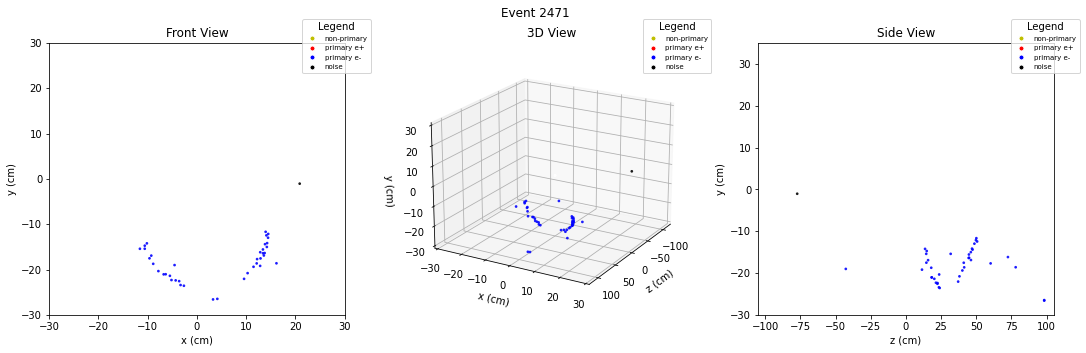

In [23]:
atk.EventSelector(testpred).plot(views="front 3D side")

In [24]:
# See the prediction contents

pred_contents = atk.get_event_contents(pred)

# Also reindex to get the same iEvent with the dataframe
pred_contents.index = crop_df.iEvent.unique()
pred_contents.index = pred_contents.index.rename("iEvent")
pred_contents

,e+,e-,sec,noise,tot
iEvent,,,,,
0,25.0,0.0,0.0,0.0,25.0
1,26.0,36.0,0.0,2.0,64.0
2,26.0,0.0,0.0,0.0,26.0
4,0.0,19.0,0.0,0.0,19.0
6,47.0,4.0,0.0,0.0,51.0
...,...,...,...,...,...
4993,11.0,16.0,0.0,0.0,27.0
4994,1.0,1.0,0.0,0.0,2.0
4996,0.0,10.0,0.0,0.0,10.0


In [25]:
# This was the acceptance condition for pair events.

pred_contents[(pred_contents["e+"] > 6) & (pred_contents["e-"] > 6)]

,e+,e-,sec,noise,tot
iEvent,,,,,
1,26.0,36.0,0.0,2.0,64.0
17,71.0,23.0,0.0,0.0,94.0
20,31.0,20.0,0.0,1.0,52.0
44,14.0,96.0,19.0,0.0,129.0
45,9.0,14.0,0.0,0.0,23.0
...,...,...,...,...,...
4977,13.0,27.0,0.0,0.0,40.0
4978,19.0,42.0,0.0,0.0,61.0
4980,62.0,102.0,0.0,0.0,164.0


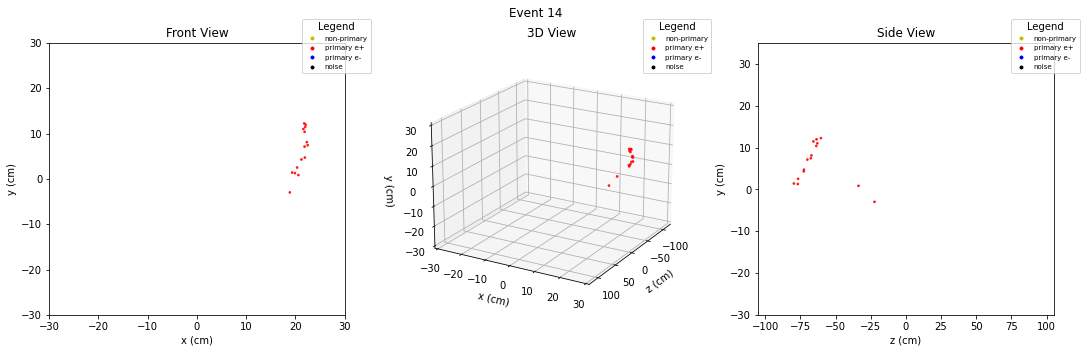

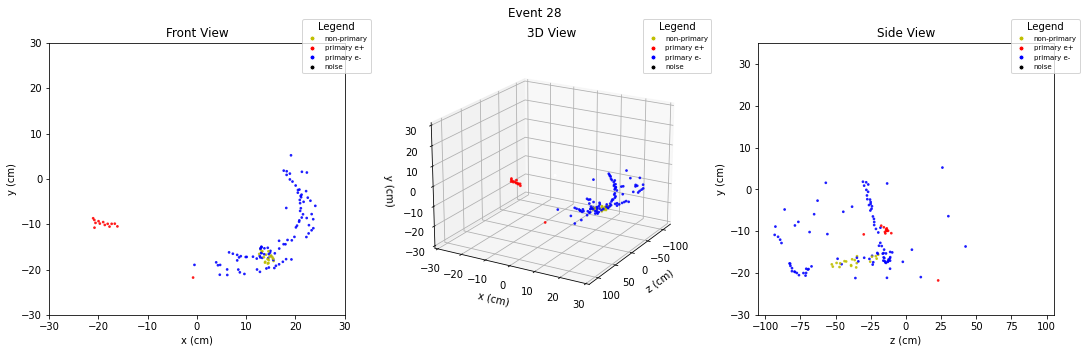

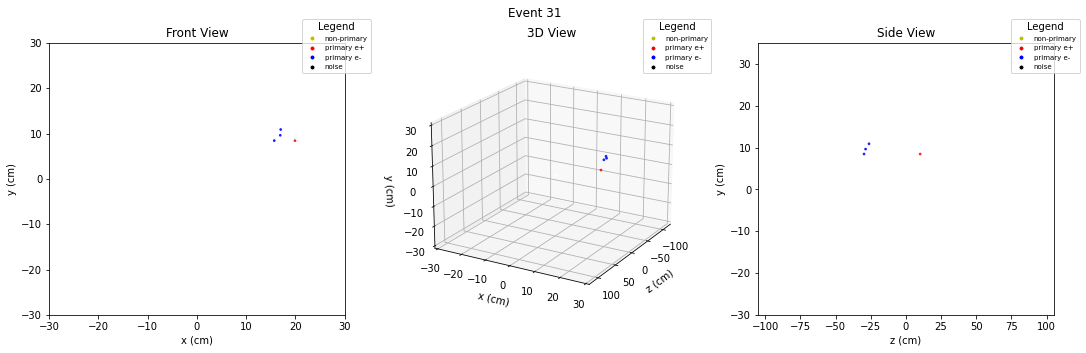

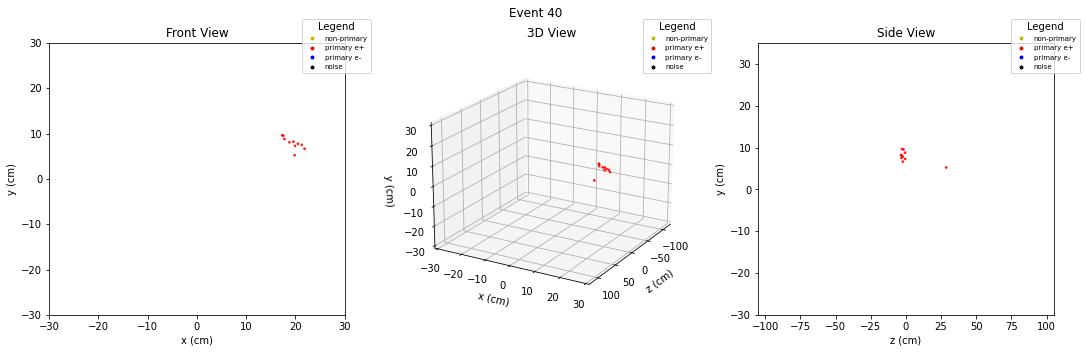

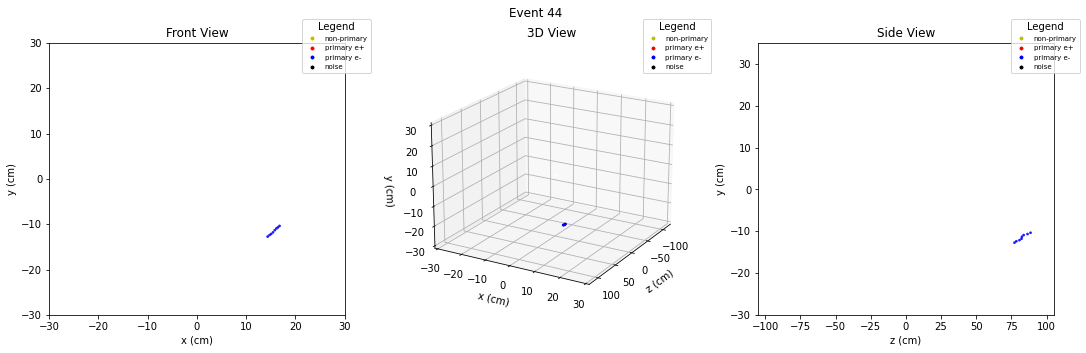

In [27]:
for i in [14,28,31,40,44]:
    atk.EventSelector(testpred, i).plot("front 3D side", save=False)

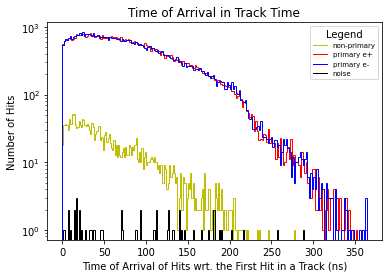

In [28]:
atk.draw_histogram(
    atk.combine_dfpred(crop_df, pred),
    np.linspace(0,100,100),
    "time of arrival - track time")

In [29]:
crop_df2 = crop_df.copy(deep=True)
crop_df2.iEvent = np.unique(crop_df.iEvent.to_numpy(),
                            return_inverse=True)[1]
crop_df2

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z
0,0,0,1,200,-2.799170e-07,-2.668260e-07,-2.663970e-07,0.475129,0.868961,-100,-100,21.9857,5.642750,-6.14229
1,0,1,1,201,-3.418840e-07,-3.295890e-07,-3.293660e-07,3.007230,2.900650,-100,-100,22.6302,6.033940,-7.05420
2,0,2,1,212,-2.565240e-07,-2.453990e-07,-2.439710e-07,20.595800,17.609300,-100,-100,23.5375,-1.296500,-20.38120
3,0,3,1,213,-3.151130e-07,-3.038010e-07,-3.015280e-07,2.340120,1.874320,-100,-100,23.5127,0.160025,-33.40430
4,0,4,1,223,-3.719570e-07,-3.589450e-07,-3.589730e-07,1.128670,0.657248,-100,-100,20.8133,-9.441430,-18.42680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117905,3612,6,5,1041,-3.638400e-07,-3.510520e-07,-3.506630e-07,1.878260,1.597230,-100,-100,-12.6584,-16.152100,10.41680
117906,3612,7,5,1042,-2.912810e-07,-2.786370e-07,-2.789220e-07,1.999010,2.042800,-100,-100,-12.0567,-15.900600,8.37652
117907,3612,8,7,1427,-4.089190e-07,-3.955960e-07,-3.963820e-07,2.436220,2.544290,-100,-100,-12.6069,-14.468400,8.22479
117908,3612,9,8,1623,-4.099570e-07,-3.974170e-07,-3.962830e-07,1.692540,1.889610,-100,-100,-11.8168,-13.799700,7.78838


In [30]:
dfpred = atk.combine_dfpred(crop_df2, pred)
dfpred

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z,track
0,0,0,1,200,-2.799170e-07,-2.668260e-07,-2.663970e-07,0.475129,0.868961,-100,-100,21.9857,5.642750,-6.14229,1
1,0,1,1,201,-3.418840e-07,-3.295890e-07,-3.293660e-07,3.007230,2.900650,-100,-100,22.6302,6.033940,-7.05420,1
2,0,2,1,212,-2.565240e-07,-2.453990e-07,-2.439710e-07,20.595800,17.609300,-100,-100,23.5375,-1.296500,-20.38120,1
3,0,3,1,213,-3.151130e-07,-3.038010e-07,-3.015280e-07,2.340120,1.874320,-100,-100,23.5127,0.160025,-33.40430,1
4,0,4,1,223,-3.719570e-07,-3.589450e-07,-3.589730e-07,1.128670,0.657248,-100,-100,20.8133,-9.441430,-18.42680,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117905,3612,6,5,1041,-3.638400e-07,-3.510520e-07,-3.506630e-07,1.878260,1.597230,-100,-100,-12.6584,-16.152100,10.41680,2
117906,3612,7,5,1042,-2.912810e-07,-2.786370e-07,-2.789220e-07,1.999010,2.042800,-100,-100,-12.0567,-15.900600,8.37652,2
117907,3612,8,7,1427,-4.089190e-07,-3.955960e-07,-3.963820e-07,2.436220,2.544290,-100,-100,-12.6069,-14.468400,8.22479,2
117908,3612,9,8,1623,-4.099570e-07,-3.974170e-07,-3.962830e-07,1.692540,1.889610,-100,-100,-11.8168,-13.799700,7.78838,2


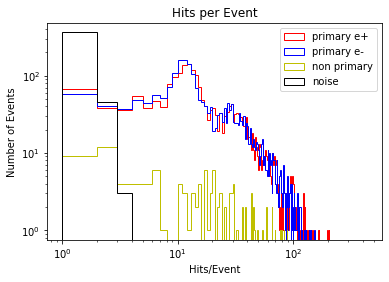

In [31]:
atk.draw_histogram(
    dfpred,
    None,
    "reconstructed hits per event")

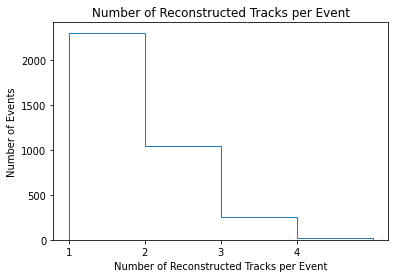

In [32]:
atk.draw_histogram(
    dfpred,
    None,
    "reconstructed tracks per event")

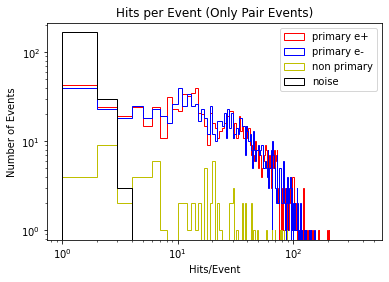

In [33]:
atk.draw_histogram(
    dfpred,
    None,
    "reconstructed hits per event (pair)")

In [34]:
dfpred.groupby("iEvent").track.value_counts()

iEvent  track
0       1        25
1       2        36
        1        26
        3         2
2       1        26
                 ..
3609    2         1
3610    2        10
3611    2        42
        3         1
3612    2         9
Name: track, Length: 5204, dtype: int64

In [35]:
dfpred.groupby("iEvent").track.value_counts().describe()

count    5204.000000
mean       22.657571
std        22.662690
min         1.000000
25%         9.000000
50%        14.000000
75%        31.000000
max       204.000000
Name: track, dtype: float64

In [39]:
pred_contents = pred_contents.groupby("tot").mean().reset_index()
pred_contents

,tot,e+,e-,sec,noise
0,1.0,0.595238,0.404762,0.0,0.000000
1,2.0,0.888889,1.111111,0.0,0.000000
2,3.0,1.421053,1.578947,0.0,0.000000
3,4.0,2.283019,1.716981,0.0,0.000000
4,5.0,2.264151,2.679245,0.0,0.056604
...,...,...,...,...,...
168,230.0,168.000000,61.000000,0.0,1.000000
169,234.0,204.000000,25.000000,5.0,0.000000
170,241.0,104.000000,137.000000,0.0,0.000000
171,250.0,147.000000,103.000000,0.0,0.000000


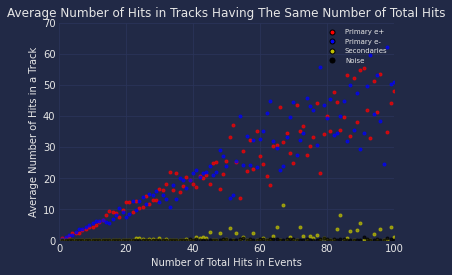

In [41]:
# Plot to see the distribution of number of hits in all tracks
# with respect to the change in the total number of hits.

plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey
# plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background

from matplotlib.lines import Line2D
leg_handles = [Line2D([0], [0], marker='o', color="None", label='Primary e+',
                   markerfacecolor='r', markersize=5),
               Line2D([0], [0], marker='o', color="None", label='Primary e-',
                   markerfacecolor='b', markersize=5),
               Line2D([0], [0], marker='o', color="None", label='Secondaries',
                   markerfacecolor='y', markersize=5),
               Line2D([0], [0], marker='o', color="None", label='Noise',
                   markerfacecolor='k', markersize=5)
               ]

plt.plot(pred_contents.tot, pred_contents["e+"], "r.", alpha=0.7)
plt.plot(pred_contents.tot, pred_contents["e-"], "b.", alpha=0.7)
plt.plot(pred_contents.tot, pred_contents["sec"], "y.", alpha=0.7)
plt.plot(pred_contents.tot, pred_contents["noise"], "k.", alpha=0.7)
plt.grid(color='#2A3459')
plt.xlim(0,100)
plt.ylim(0,70)
plt.title("Average Number of Hits in Tracks Having The Same Number of Total Hits")
plt.xlabel("Number of Total Hits in Events")
plt.ylabel("Average Number of Hits in a Track")
plt.legend(handles=leg_handles, loc="upper right", fontsize=7)
# plt.title("Mean of Non-Primary Hits per Event When Primary Pairs are in Acceptance")
# plt.xlabel("Hits per Event")
# plt.ylabel("Average Noise Hits per Event")
plt.savefig("plots/mean_tracks_all.png", dpi=300, bbox_inches='tight')

In [ ]:
# To revert the seaborn plot styling:
# plt.style.use("default")
